# IMDB Review Predictor

Author: Daeseo Lee

Course Project, UC Irvine, Math 10, Spring 25

I would like to post my notebook on the course's website. Yes

# Dataset

For this project, I decided to use the [IMDB Reviews Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)

This dataset is composed of 50,000 IMDB Movie reviews. Each review is associated with a rating from 1 - 10, where 1 is a very negative review and 10 is a very positive review.

My goal for this  will be to create a model which can accurately predict the rating (1 - 10) given the review text.

# Understanding the Data

First let's load the data.

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import re

DATASET_PATH = Path("imdb_data")

def load_reviews_in_directory(directory: Path):
    """
    Load all review text files from a specific directory.
    Extracts ratings from filenames (format: id_rating.txt)
    
    Args:
        directory: Path to directory containing text review files
        
    Returns:
        features: numpy array of review texts
        labels: numpy array of ratings (extracted from filenames)
    """
    reviews = []
    ratings = []
    
    if directory.exists():
        for file_path in directory.glob("*.txt"):
            # Extract rating from filename (format: id_rating.txt)
            rating = int(re.search(r'_(\d+)\.txt$', file_path.name).group(1))
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                reviews.append(f.read())
            ratings.append(rating)
    
    return np.array(reviews), np.array(ratings)

# Load training data from both negative and positive directories
train_neg_dir = DATASET_PATH / "train" / "neg"
train_pos_dir = DATASET_PATH / "train" / "pos"

X_train_neg, y_train_neg = load_reviews_in_directory(train_neg_dir)
X_train_pos, y_train_pos = load_reviews_in_directory(train_pos_dir)

X_train = np.concatenate([X_train_neg, X_train_pos])
y_train = np.concatenate([y_train_neg, y_train_pos])

test_neg_dir = DATASET_PATH / "test" / "neg"
test_pos_dir = DATASET_PATH / "test" / "pos"

X_test_neg, y_test_neg = load_reviews_in_directory(test_neg_dir)
X_test_pos, y_test_pos = load_reviews_in_directory(test_pos_dir)

# Combine
X_test = np.concatenate([X_test_neg, X_test_pos])
y_test = np.concatenate([y_test_neg, y_test_pos])
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")

# Create a sample 
train_sample = pd.DataFrame({
    'review': X_train[:5],
    'rating': y_train[:5]
})

train_sample

Training data shape: (25000,), Labels shape: (25000,)
Test data shape: (25000,), Labels shape: (25000,)


review  rating
0  Working with one of the best Shakespeare sourc...       4
1  Well...tremors I, the original started off in ...       1
2  Ouch! This one was a bit painful to sit throug...       4
3  I've seen some crappy movies in my life, but t...       1
4  "Carriers" follows the exploits of two guys an...       3

Now let's plot the distribution of ratings so we can get a feel for the data as a whole.

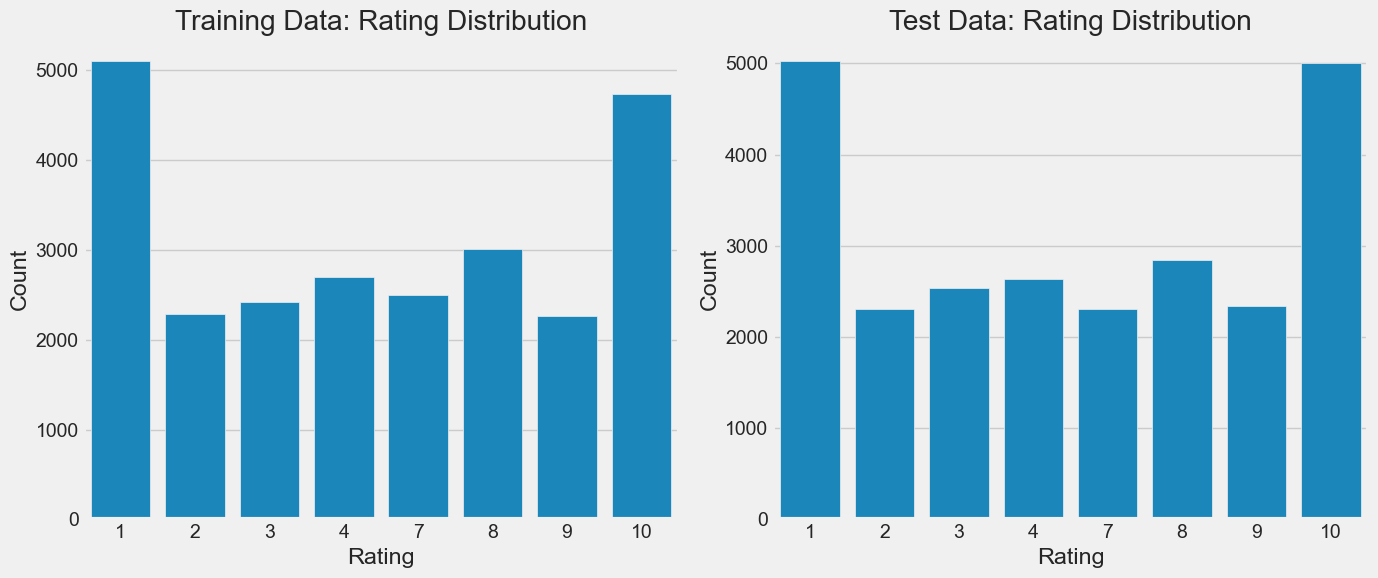

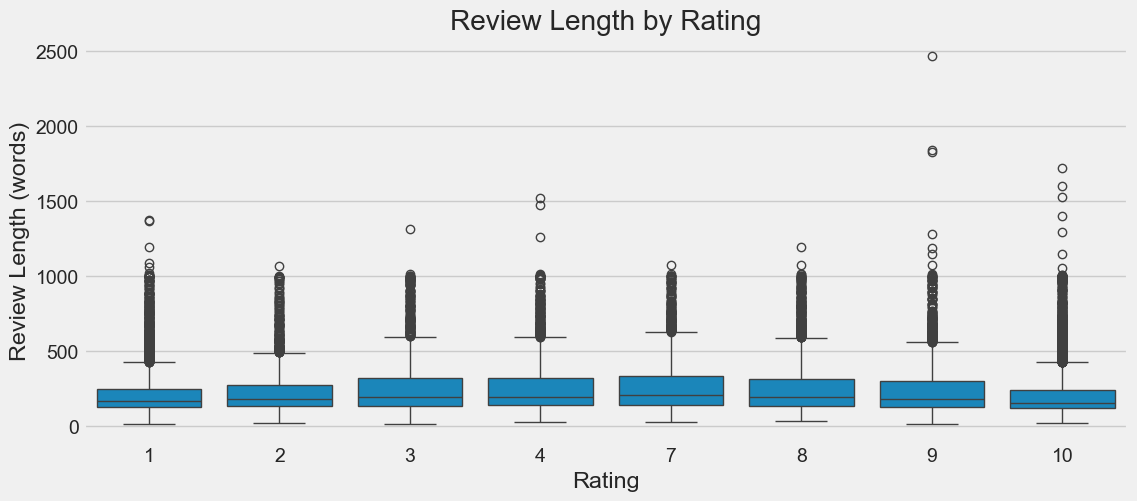

Rating Distribution in Training Data:
1     5100
2     2284
3     2420
4     2696
7     2496
8     3009
9     2263
10    4732
Name: count, dtype: int64


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better visualizations
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14, 6))

# Create a subplot for training data
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Training Data: Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

# Create a subplot for test data
plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Test Data: Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Let's also look at the average length of reviews by rating
train_df = pd.DataFrame({
    'review': X_train,
    'rating': y_train,
    'length': [len(text.split()) for text in X_train]
})

plt.figure(figsize=(12, 5))
sns.boxplot(x='rating', y='length', data=train_df)
plt.title('Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length (words)')
plt.show()

# Summary statistics
print("Rating Distribution in Training Data:")
print(pd.Series(y_train).value_counts().sort_index())

Looking at these graphs, we can make some important observations:

1. There are no ratings of 5 or 6 in this dataset. 
2. There are significantly more extreme ratings, 1 or 10, than other ratings.
3. Review lengths seem to vary very little.
4. The training and testing data have similar distributions.

# Attempt 1

This first attempt will be simple. To encode the meaning of words we will word2vec, but to minimize the size of the model we will simply average the word vectors for each review. We'll use a linear model.
Let's see where that gets us.

Tokenizing reviews...
Tokenization completed in 30.13 seconds
Training Word2Vec model...
Word2Vec training completed in 10.93 seconds
Creating review vectors...
Review vectorization completed in 9.08 seconds
Word2Vec training data shape: (25000, 100)
Word2Vec test data shape: (25000, 100)
Training linear regression model...
Model training completed in 0.07 seconds
Mean Squared Error: 6.9167
Mean Absolute Error: 2.1730
R² Score: 0.4324
Exact Match Accuracy: 0.1444


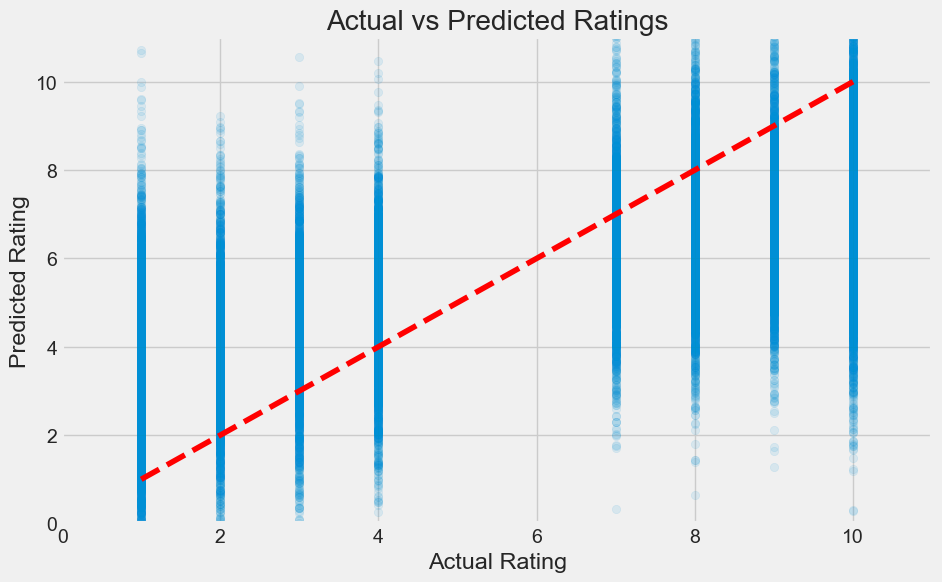

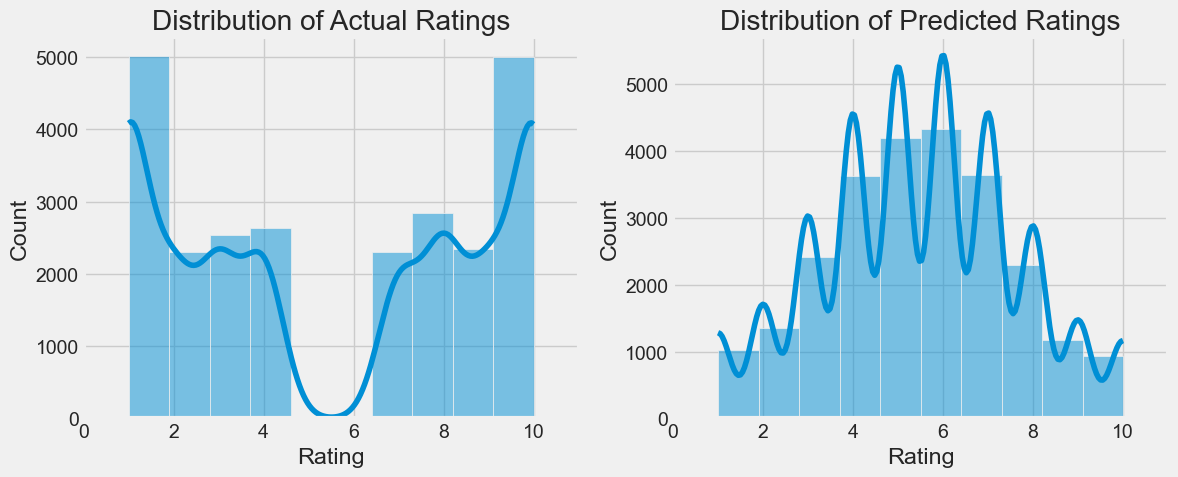

In [3]:
from gensim.models import Word2Vec
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import nltk
import string
import time
from nltk.tokenize import word_tokenize

# Download tokenizer data if not already present
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')

# tokenize and remove punctuation
def preprocess_text(text):
    # Convert to lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    return tokens

print("Tokenizing reviews...")
start_time = time.time()
tokenized_train = [preprocess_text(review) for review in X_train]
tokenized_test = [preprocess_text(review) for review in X_test]
print(f"Tokenization completed in {time.time() - start_time:.2f} seconds")

# Train Word2Vec model
print("Training Word2Vec model...")
start_time = time.time()
# Simple Word2Vec model with minimal parameters
w2v_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=100,  # Dimension of word vectors
    window=5,         # Context window size
    min_count=5,      # Minimum word frequency
    workers=4         # Number of threads
)
print(f"Word2Vec training completed in {time.time() - start_time:.2f} seconds")

# Create review vectors by averaging word vectors
def get_review_vector(tokenized_review, model):
    vectors = []
    for word in tokenized_review:
        if word in model.wv:
            vectors.append(model.wv[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

print("Creating review vectors...")
start_time = time.time()
X_train_w2v = np.array([get_review_vector(review, w2v_model) for review in tokenized_train])
X_test_w2v = np.array([get_review_vector(review, w2v_model) for review in tokenized_test])
print(f"Review vectorization completed in {time.time() - start_time:.2f} seconds")
print(f"Word2Vec training data shape: {X_train_w2v.shape}")
print(f"Word2Vec test data shape: {X_test_w2v.shape}")

print("Training linear regression model...")
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train_w2v, y_train)
print(f"Model training completed in {time.time() - start_time:.2f} seconds")

y_pred = lr_model.predict(X_test_w2v)

y_pred_rounded = np.clip(np.round(y_pred), 1, 10)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = np.mean(y_pred_rounded == y_test)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Exact Match Accuracy: {accuracy:.4f}")


# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([1, 10], [1, 10], 'r--')
plt.xlim(0, 11)
plt.ylim(0, 11)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(y_test, bins=10, kde=True)
plt.title('Distribution of Actual Ratings')
plt.xlabel('Rating')
plt.xlim(0, 11)

plt.subplot(1, 2, 2)
sns.histplot(y_pred_rounded, bins=10, kde=True)
plt.title('Distribution of Predicted Ratings')
plt.xlabel('Rating')
plt.xlim(0, 11)

plt.tight_layout()
plt.show()

As we can see we are not matching the data at all. It seems that our model is simply outputing what looks like to be a normal distribution. This is plausible given that our word to vex is based on averages and is more likely to create average looking inputs. Nonetheless, let's try and play with we with the word to vector encoding and see if we can extract more data from it for the linear regression model.

We're going to try varying the vector encoding size and see if that lets us increase the exact match accuracy of 0.14 that were currently hitting.

Let's hit a range from 10 to 200 in steps of 10 and graph the results.

Training with vector size: 10
Word2Vec training completed in 6.79 seconds
Review vectorization completed in 9.61 seconds
Training with vector size: 20
Word2Vec training completed in 8.26 seconds
Review vectorization completed in 9.91 seconds
Training with vector size: 30
Word2Vec training completed in 8.88 seconds
Review vectorization completed in 9.70 seconds
Training with vector size: 40
Word2Vec training completed in 7.69 seconds
Review vectorization completed in 9.31 seconds
Training with vector size: 50
Word2Vec training completed in 7.97 seconds
Review vectorization completed in 9.73 seconds
Training with vector size: 60
Word2Vec training completed in 9.25 seconds
Review vectorization completed in 9.89 seconds
Training with vector size: 70
Word2Vec training completed in 9.16 seconds
Review vectorization completed in 10.10 seconds
Training with vector size: 80
Word2Vec training completed in 9.32 seconds
Review vectorization completed in 9.92 seconds
Training with vector size: 90
W

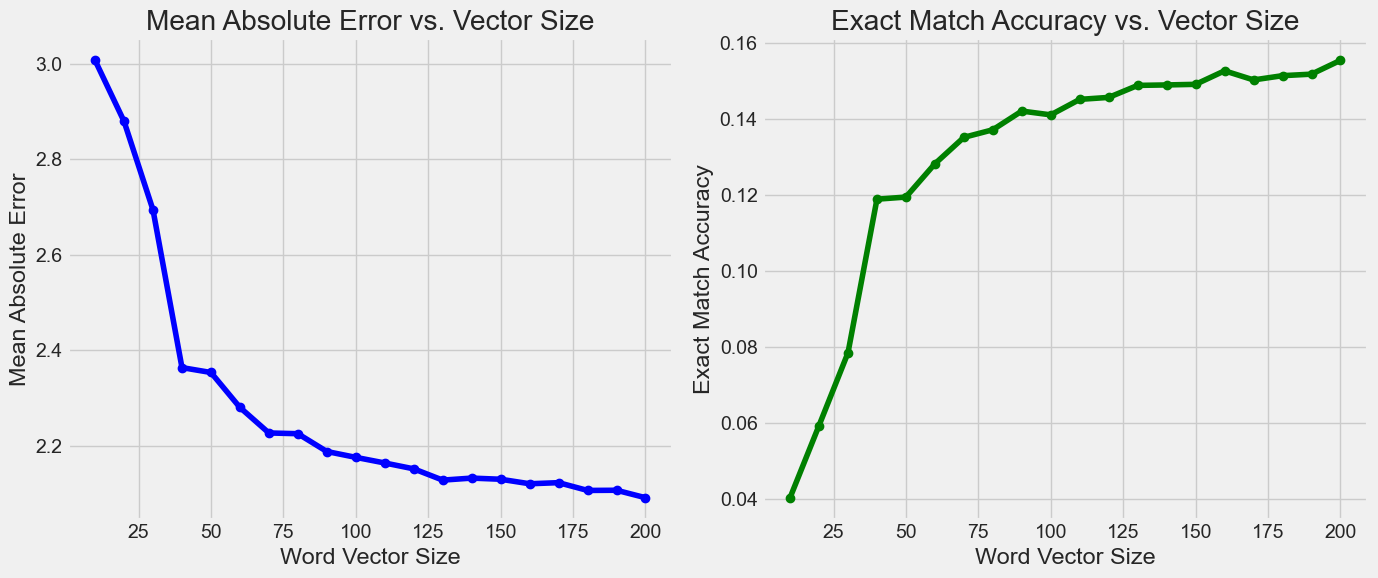

Best Mean Absolute Error: 2.0907 with vector size 200
Best Exact Match Accuracy: 0.1556 with vector size 200


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from gensim.models import Word2Vec
import time

# Vector sizes to try
vector_sizes = list(range(10, 201, 10))  # 10, 20, 30, ..., 200
mae_results = []
accuracy_results = []

for size in vector_sizes:
    print(f"Training with vector size: {size}")

    # Train Word2Vec model with current size
    start_time = time.time()
    w2v_model = Word2Vec(
        sentences=tokenized_train,
        vector_size=size,  # Variable dimension
        window=5,
        min_count=5,
        workers=4
    )
    print(f"Word2Vec training completed in {time.time() - start_time:.2f} seconds")

    # Create review vectors
    start_time = time.time()
    X_train_w2v = np.array([get_review_vector(review, w2v_model) for review in tokenized_train])
    X_test_w2v = np.array([get_review_vector(review, w2v_model) for review in tokenized_test])
    print(f"Review vectorization completed in {time.time() - start_time:.2f} seconds")

    # Train and evaluate linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train_w2v, y_train)

    # Make predictions
    y_pred = lr_model.predict(X_test_w2v)
    y_pred_rounded = np.clip(np.round(y_pred), 1, 10)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    accuracy = np.mean(y_pred_rounded == y_test)

    # Store results
    mae_results.append(mae)
    accuracy_results.append(accuracy)


# Plot results
plt.figure(figsize=(14, 6))

# Plot Mean Absolute Error
plt.subplot(1, 2, 1)
plt.plot(vector_sizes, mae_results, marker='o', linestyle='-', color='blue')
plt.xlabel('Word Vector Size')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Vector Size')
plt.grid(True)

# Plot Exact Match Accuracy
plt.subplot(1, 2, 2)
plt.plot(vector_sizes, accuracy_results, marker='o', linestyle='-', color='green')
plt.xlabel('Word Vector Size')
plt.ylabel('Exact Match Accuracy')
plt.title('Exact Match Accuracy vs. Vector Size')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the best results
best_mae_idx = np.argmin(mae_results)
best_acc_idx = np.argmax(accuracy_results)

print(f"Best Mean Absolute Error: {mae_results[best_mae_idx]:.4f} with vector size {vector_sizes[best_mae_idx]}")
print(f"Best Exact Match Accuracy: {accuracy_results[best_acc_idx]:.4f} with vector size {vector_sizes[best_acc_idx]}")

As you can see we are getting better results with a larger vector encoding. The improvement is diminishing though. Also, the improvement may just be because it flattens the normal distribution and moves more data towards the edges. We know from analyzing the data in the introduction that there are more samples with ratings 1 and 10 therefore flattening the distribution will improve the results because it makes the model  select one of the extremes either one or 10. This means that these improvements are not necessarily the model getting smarter, but me tricking myself into thinking the model is better. Let's try something other than linear regression.

# Attempt 2

Let's try a simple neural network with a single hidden layer. We'll use PyTorch to build the model and train it on the Word2Vec vectors I created earlier.

Starting training...
Training completed in 30.41 seconds


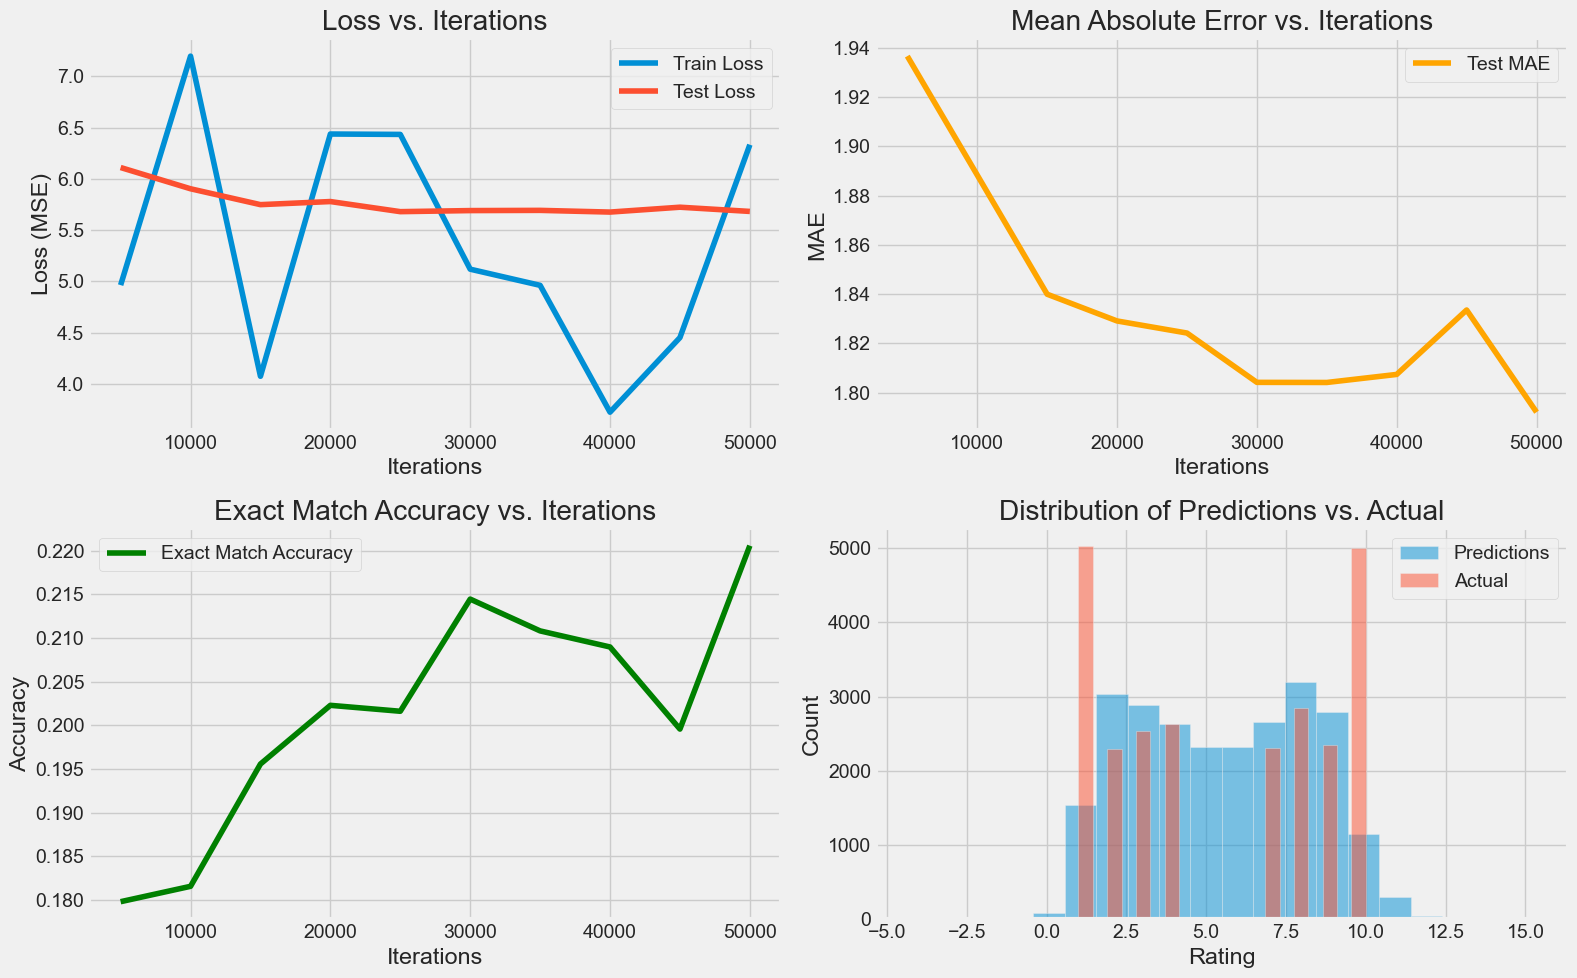


Final Model Performance:
MSE: 5.6823
MAE: 1.7921
Exact Match Accuracy: 0.2206


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_w2v)
y_train_tensor = torch.FloatTensor(y_train.astype(float)).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_w2v)
y_test_tensor = torch.FloatTensor(y_test.astype(float)).reshape(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the neural network with 2 layers
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# Initialize the model
input_size = X_train_w2v.shape[1]  # Word2Vec dimension (100)
hidden_size = 50  # Hidden layer size
output_size = 1  # Single output (rating)
model = TwoLayerNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
total_iterations = 50000  # Total number of iterations
eval_interval = 5000  # Evaluate every 5000 iterations
current_iter = 0

# Lists to track performance metrics
train_losses = []
test_losses = []
test_maes = []
test_accuracies = []
iterations = []

print("Starting training...")
start_time = time.time()

while current_iter < total_iterations:
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track iterations
        current_iter += 1

        # Evaluate performance every eval_interval iterations
        if current_iter % eval_interval == 0 or current_iter == total_iterations:
            model.eval()
            with torch.no_grad():
                # Calculate training loss
                train_loss = loss.item()
                train_losses.append(train_loss)

                # Calculate test metrics
                test_preds = []
                test_targets = []
                test_loss = 0

                for test_inputs, test_targets_batch in test_loader:
                    test_outputs = model(test_inputs)
                    test_loss += criterion(test_outputs, test_targets_batch).item() * test_inputs.size(0)
                    test_preds.extend(test_outputs.numpy().flatten())
                    test_targets.extend(test_targets_batch.numpy().flatten())

                test_loss /= len(test_dataset)
                test_losses.append(test_loss)

                # Calculate additional metrics
                test_mae = mean_absolute_error(test_targets, test_preds)
                test_maes.append(test_mae)
                
                # Calculate accuracy (exact matches after rounding)
                test_preds_rounded = np.clip(np.round(test_preds), 1, 10)
                test_accuracy = np.mean(test_preds_rounded == np.array(test_targets))
                test_accuracies.append(test_accuracy)

                iterations.append(current_iter)

            model.train()

        # Break the loop if we've reached total iterations
        if current_iter >= total_iterations:
            break

print(f"Training completed in {time.time() - start_time:.2f} seconds")

# Plot the performance metrics
plt.figure(figsize=(16, 10))

# Plot training and test losses
plt.subplot(2, 2, 1)
plt.plot(iterations, train_losses, label='Train Loss')
plt.plot(iterations, test_losses, label='Test Loss')
plt.title('Loss vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot test MAE
plt.subplot(2, 2, 2)
plt.plot(iterations, test_maes, label='Test MAE', color='orange')
plt.title('Mean Absolute Error vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(2, 2, 3)
plt.plot(iterations, test_accuracies, label='Exact Match Accuracy', color='green')
plt.title('Exact Match Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Predictions distribution
plt.subplot(2, 2, 4)
model.eval()
with torch.no_grad():
    final_predictions = model(X_test_tensor).numpy().flatten()

plt.hist(final_predictions, bins=20, alpha=0.5, label='Predictions')
plt.hist(y_test, bins=20, alpha=0.5, label='Actual')
plt.title('Distribution of Predictions vs. Actual')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()
    y_pred_rounded = np.clip(np.round(y_pred), 1, 10)

    final_mse = mean_squared_error(y_test, y_pred)
    final_mae = mean_absolute_error(y_test, y_pred)
    final_accuracy = np.mean(y_pred_rounded == y_test)

    print("\nFinal Model Performance:")
    print(f"MSE: {final_mse:.4f}")
    print(f"MAE: {final_mae:.4f}")
    print(f"Exact Match Accuracy: {final_accuracy:.4f}")

This is looking much better. Not only is our exact match accuracy 3 percent higher, but I can start to see the the U shape of the dataset in the shape of the predictions. In this version though we made it so that the model only has one output node. We are currently treating this problem as a regression problem but it may be a better idea to consider a classification problem with 10 output nodes.

Let's also going to switch functions to RELU because apparently they are better suited for classification problems.

Starting training...
Training completed in 63.74 seconds


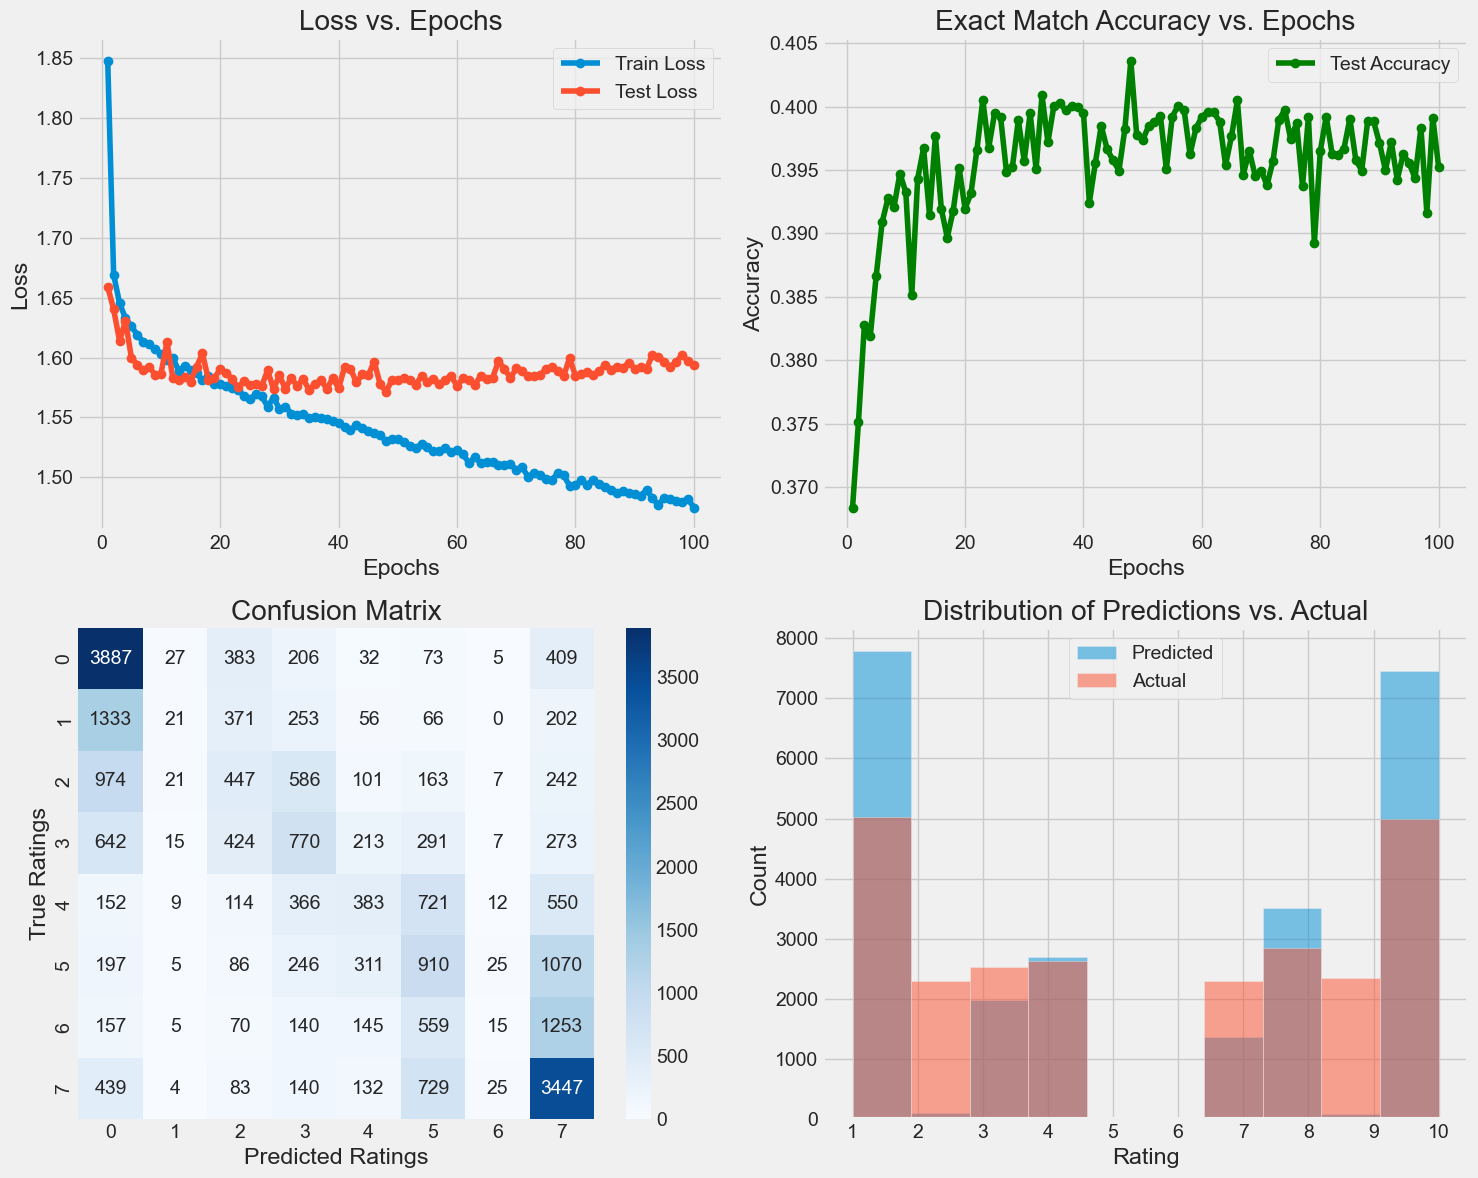


Final Model Performance (Classification):
Test Loss: 1.5939
Exact Match Accuracy: 0.3952

Comparison with Regression Model:
Regression Model Accuracy: 0.2206
Classification Model Accuracy: 0.3952
Improvement: 17.46%


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_w2v)
# For classification, we need class indices from 0 to 9 (for 10 classes)
# But our ratings are 1-10, so we subtract 1 to get 0-9 indices
y_train_class = y_train - 1
y_train_tensor = torch.LongTensor(y_train_class)
X_test_tensor = torch.FloatTensor(X_test_w2v)
y_test_class = y_test - 1
y_test_tensor = torch.LongTensor(y_test_class)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the neural network classifier
class RatingClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RatingClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        # Hidden layer with ReLU activation - good for intermediate layers
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, num_classes)
        # No activation here as CrossEntropyLoss includes softmax

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x  # Logits, CrossEntropyLoss will apply softmax internally

# Initialize the model
input_size = X_train_w2v.shape[1]  # Word2Vec dimension
hidden_size = 128  # Larger hidden layer for more capacity
num_classes = 10  # 10 possible ratings (1-10)
model = RatingClassifier(input_size, hidden_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Standard for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added L2 regularization

num_epochs = 100
eval_interval = 1
train_losses = []
test_losses = []
test_accuracies = []
epochs = []

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Calculate epoch loss
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_preds = []
        test_targets = []
        
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())
        
        # Calculate test metrics
        test_loss /= len(test_dataset)
        test_losses.append(test_loss)
        
        # Calculate accuracy
        test_accuracy = accuracy_score(test_targets, test_preds)
        test_accuracies.append(test_accuracy)
        
        epochs.append(epoch + 1)
        
        # Convert back to 1-10 ratings for reporting
        test_preds_ratings = np.array(test_preds) + 1
        test_targets_ratings = np.array(test_targets) + 1
   

print(f"Training completed in {time.time() - start_time:.2f} seconds")

# Plot the performance metrics
plt.figure(figsize=(15, 12))

# Plot training and test losses
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, test_losses, marker='o', label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, test_accuracies, marker='o', label='Test Accuracy', color='green')
plt.title('Exact Match Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Confusion matrix
model.eval()
with torch.no_grad():
    test_preds = []
    
    for inputs, _ in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
    
    # Convert predictions back to 1-10 scale for display
    test_preds_ratings = np.array(test_preds) + 1

# Create confusion matrix
cm = confusion_matrix(y_test, test_preds_ratings)
plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Ratings')
plt.ylabel('True Ratings')

# Predictions distribution
plt.subplot(2, 2, 4)
plt.hist(test_preds_ratings, bins=10, alpha=0.5, label='Predicted')
plt.hist(y_test, bins=10, alpha=0.5, label='Actual')
plt.title('Distribution of Predictions vs. Actual')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final evaluation
print("\nFinal Model Performance (Classification):")
print(f"Test Loss: {test_losses[-1]:.4f}")
print(f"Exact Match Accuracy: {test_accuracies[-1]:.4f}")

# Compare with previous regression model's accuracy
print(f"\nComparison with Regression Model:")
print(f"Regression Model Accuracy: {final_accuracy:.4f}")
print(f"Classification Model Accuracy: {test_accuracies[-1]:.4f}")
print(f"Improvement: {(test_accuracies[-1] - final_accuracy) * 100:.2f}%")


This looking much better! The exact match accuracy is nearly double what we had before. Not only that but the prediction distribution is starting to look very good.
One thing to note is that I am severely overfitting. If we look at the Entropy vs Loss graph we can clearly see the point at which the Test Loss stops improving (infact it gets worse) but the training loss is still getting smaller and smaller.

Let's try reducing the hidden layer size to see if we can reduce the overfitting.

Starting training...
Training completed in 51.78 seconds


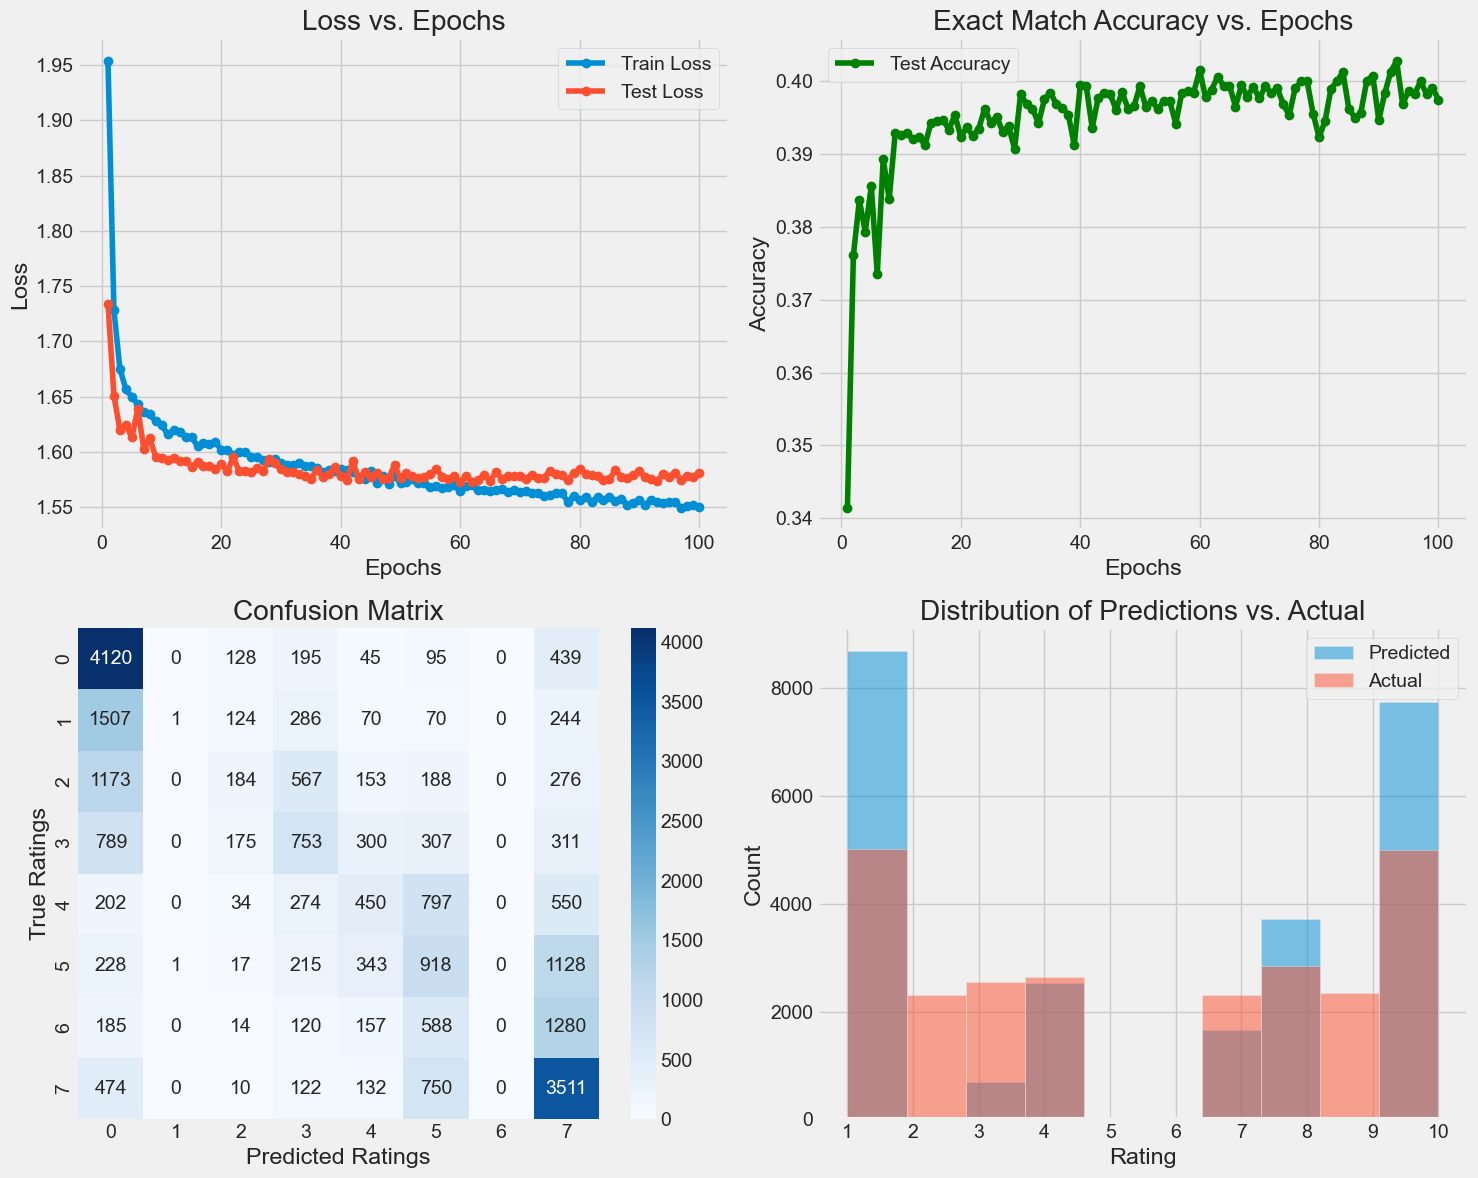


Final Model Performance (Classification):
Test Loss: 1.5808
Exact Match Accuracy: 0.3975

Comparison with Regression Model:
Regression Model Accuracy: 0.2206
Classification Model Accuracy: 0.3975
Improvement: 17.69%


In [7]:
# Define the neural network classifier
class RatingClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RatingClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, num_classes)
        # No activation here as CrossEntropyLoss includes softmax

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x  # Logits, CrossEntropyLoss will apply softmax internally

input_size = X_train_w2v.shape[1] 
hidden_size = 50  
num_classes = 10  
model = RatingClassifier(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()  # Standard for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added L2 regularization

num_epochs = 100
eval_interval = 1  # Evaluate after each epoch

train_losses = []
test_losses = []
test_accuracies = []
epochs = []

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Calculate epoch loss
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_preds = []
        test_targets = []
        
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())
        
        # Calculate test metrics
        test_loss /= len(test_dataset)
        test_losses.append(test_loss)
        
        # Calculate accuracy
        test_accuracy = accuracy_score(test_targets, test_preds)
        test_accuracies.append(test_accuracy)
        
        epochs.append(epoch + 1)
        
        # Convert back to 1-10 ratings for reporting
        test_preds_ratings = np.array(test_preds) + 1
        test_targets_ratings = np.array(test_targets) + 1
       

print(f"Training completed in {time.time() - start_time:.2f} seconds")

# Plot the performance metrics
plt.figure(figsize=(15, 12))

# Plot training and test losses
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, test_losses, marker='o', label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, test_accuracies, marker='o', label='Test Accuracy', color='green')
plt.title('Exact Match Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Confusion matrix
model.eval()
with torch.no_grad():
    test_preds = []
    
    for inputs, _ in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
    
    # Convert predictions back to 1-10 scale for display
    test_preds_ratings = np.array(test_preds) + 1

# Create confusion matrix
cm = confusion_matrix(y_test, test_preds_ratings)
plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Ratings')
plt.ylabel('True Ratings')

# Predictions distribution
plt.subplot(2, 2, 4)
plt.hist(test_preds_ratings, bins=10, alpha=0.5, label='Predicted')
plt.hist(y_test, bins=10, alpha=0.5, label='Actual')
plt.title('Distribution of Predictions vs. Actual')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final evaluation
print("\nFinal Model Performance (Classification):")
print(f"Test Loss: {test_losses[-1]:.4f}")
print(f"Exact Match Accuracy: {test_accuracies[-1]:.4f}")

# Compare with previous regression model's accuracy
print(f"\nComparison with Regression Model:")
print(f"Regression Model Accuracy: {final_accuracy:.4f}")
print(f"Classification Model Accuracy: {test_accuracies[-1]:.4f}")
print(f"Improvement: {(test_accuracies[-1] - final_accuracy) * 100:.2f}%")

Although the overfitting has been improved the exact match accuracy has not gone up.

Something that is strange about this model is that it almost never predicts 2, 3, and 9. Why these numbers specifically? I have no idea.

Something I think could improve the model is if when calcualing the review word2vec average we did it as a sum rather than an average. This may help for multiple reasons:
1. It would make it so that words like the, he, we would not dilute away the meaningful dimensions
2. Average do not convey how many words of a certain dimension were in the review, but if the vector were simply calculated by addition this information would be able to come through.
                                                                                                         
Of course, I would need to normalize all the review vectors so that the data is fit for use by the neural network...

Creating review vectors...
Review vectorization completed in 10.34 seconds
Starting training...
Training completed in 49.91 seconds


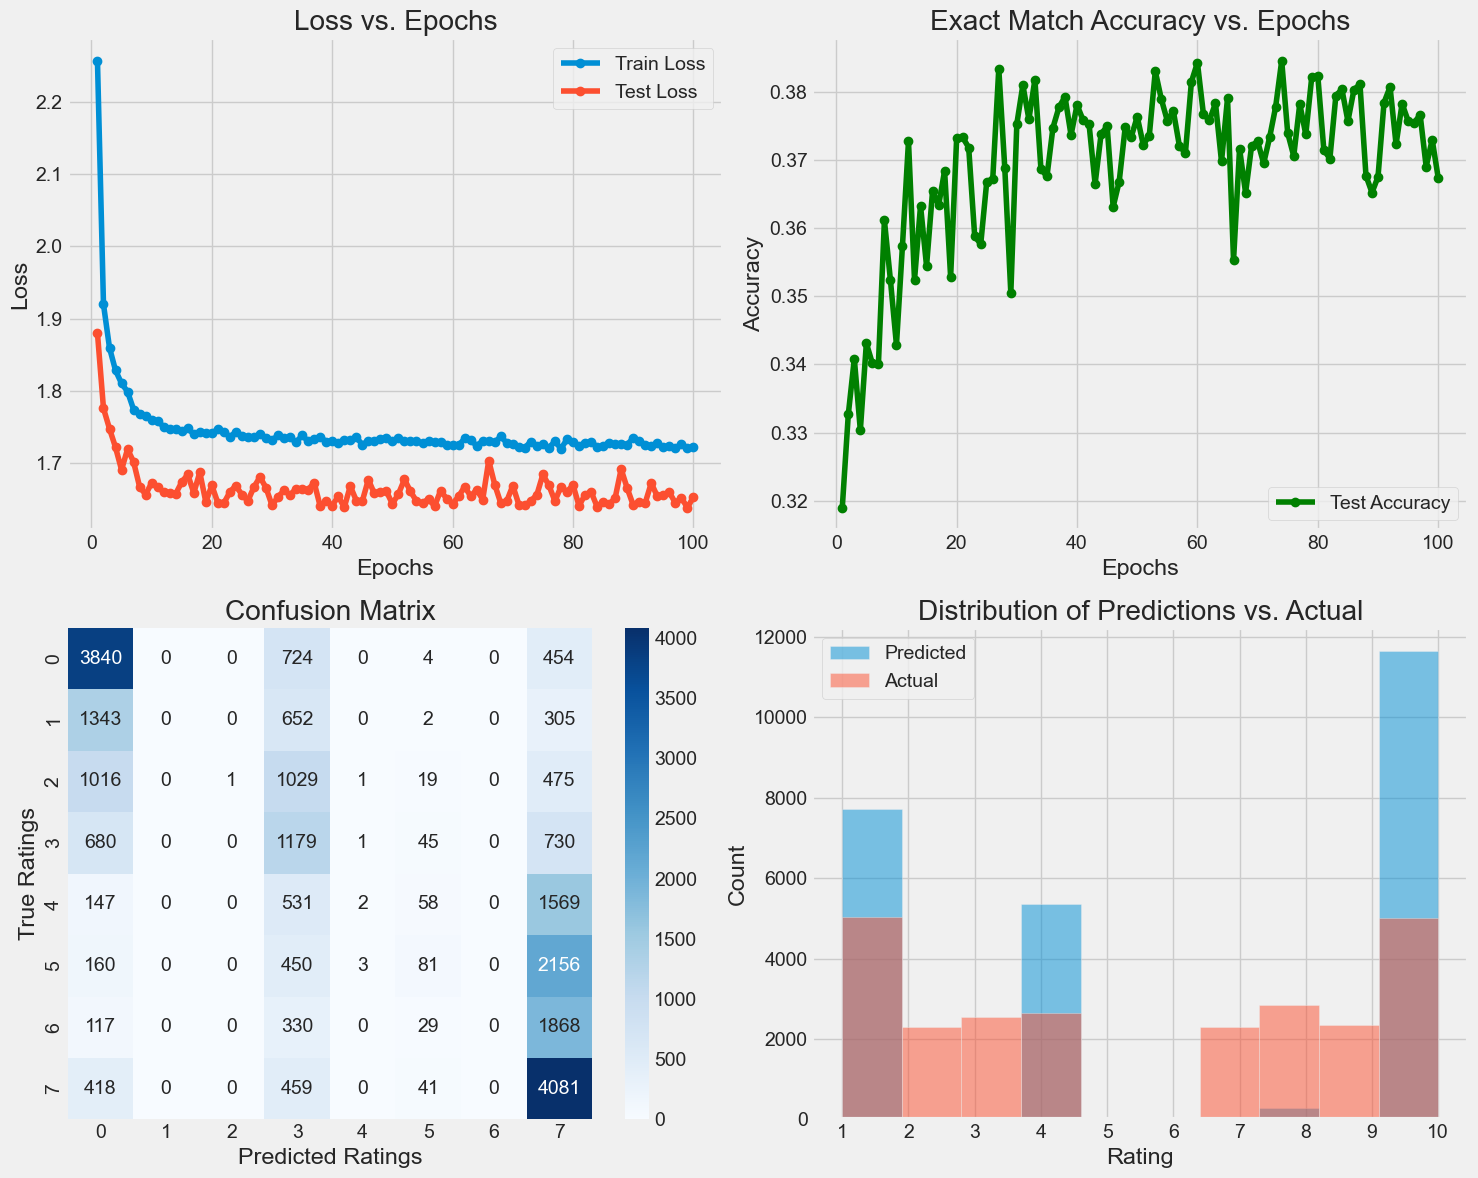


Final Model Performance (Classification):
Test Loss: 1.6526
Exact Match Accuracy: 0.3674

Comparison with Regression Model:
Regression Model Accuracy: 0.2206
Classification Model Accuracy: 0.3674
Improvement: 14.68%


In [9]:
# Create review vectors by averaging word vectors
def get_review_vector_sum(tokenized_review, model):
    vectors = [model.wv[word] 
               for word in tokenized_review 
               if word in model.wv]
    if vectors:
        return np.sum(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


print("Creating review vectors...")
start_time = time.time()
X_train_w2v = np.array([get_review_vector_sum(review, w2v_model) for review in tokenized_train])
X_test_w2v = np.array([get_review_vector_sum(review, w2v_model) for review in tokenized_test])
print(f"Review vectorization completed in {time.time() - start_time:.2f} seconds")

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_w2v)
# For classification, we need class indices from 0 to 9 (for 10 classes)
# But our ratings are 1-10, so we subtract 1 to get 0-9 indices
y_train_class = y_train - 1
y_train_tensor = torch.LongTensor(y_train_class)
X_test_tensor = torch.FloatTensor(X_test_w2v)
y_test_class = y_test - 1
y_test_tensor = torch.LongTensor(y_test_class)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the neural network classifier
class RatingClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RatingClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, num_classes)
        # No activation here as CrossEntropyLoss includes softmax

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x  

input_size = X_train_w2v.shape[1] 
hidden_size = 50 
num_classes = 10 
model = RatingClassifier(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 100
eval_interval = 1 

train_losses = []
test_losses = []
test_accuracies = []
epochs = []

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Calculate epoch loss
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_preds = []
        test_targets = []
        
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())
        
        # Calculate test metrics
        test_loss /= len(test_dataset)
        test_losses.append(test_loss)
        
        # Calculate accuracy
        test_accuracy = accuracy_score(test_targets, test_preds)
        test_accuracies.append(test_accuracy)
        
        epochs.append(epoch + 1)
        
        # Convert back to 1-10 ratings for reporting
        test_preds_ratings = np.array(test_preds) + 1
        test_targets_ratings = np.array(test_targets) + 1
       

print(f"Training completed in {time.time() - start_time:.2f} seconds")

# Plot the performance metrics
plt.figure(figsize=(15, 12))

# Plot training and test losses
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, test_losses, marker='o', label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, test_accuracies, marker='o', label='Test Accuracy', color='green')
plt.title('Exact Match Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Confusion matrix
model.eval()
with torch.no_grad():
    test_preds = []
    
    for inputs, _ in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
    
    # Convert predictions back to 1-10 scale for display
    test_preds_ratings = np.array(test_preds) + 1

# Create confusion matrix
cm = confusion_matrix(y_test, test_preds_ratings)
plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Ratings')
plt.ylabel('True Ratings')

# Predictions distribution
plt.subplot(2, 2, 4)
plt.hist(test_preds_ratings, bins=10, alpha=0.5, label='Predicted')
plt.hist(y_test, bins=10, alpha=0.5, label='Actual')
plt.title('Distribution of Predictions vs. Actual')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final evaluation
print("\nFinal Model Performance (Classification):")
print(f"Test Loss: {test_losses[-1]:.4f}")
print(f"Exact Match Accuracy: {test_accuracies[-1]:.4f}")

# Compare with previous regression model's accuracy
print(f"\nComparison with Regression Model:")
print(f"Regression Model Accuracy: {final_accuracy:.4f}")
print(f"Classification Model Accuracy: {test_accuracies[-1]:.4f}")
print(f"Improvement: {(test_accuracies[-1] - final_accuracy) * 100:.2f}%")